<h1><center> Emotions in context (Emotic) </center></h1>
<center> Robustness_Evaluation model</center>

# I. Prepare places pretrained model

In [1]:
import os
import requests
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pickle
from pathlib import Path
import warnings

Purpose: Downloads and prepares the pre-trained Places365 ResNet18 model for context feature extraction.

Essential for initializing the context feature extractor.

Summary: This section downloads a pre-trained ResNet18 model on the Places365 dataset, which is used to extract contextual features from images.

In [2]:
# Create a directory to save the model
os.makedirs("places", exist_ok=True)

# URL of the ResNet model
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

# Download the model if not already downloaded
if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")


Model already exists.


In [3]:
# Saving the model weights to use ahead in the notebook

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. SAFE SERIALIZATION SETTINGS

Purpose: The function configures PyTorch's serialization system to safely handle numpy scalar types during model loading and saving.

PyTorch implemented stricter security measures in newer versions that restrict certain data types during serialization/deserialization, requiring explicit whitelisting of numpy scalar types to prevent serialization errors.

Summary: The code registers numpy scalar types as "safe globals" in PyTorch's serialization system, enabling proper loading and saving of models containing numpy values while maintaining security protections against arbitrary code execution.

In [4]:
# === SAFE SERIALIZATION SETTINGS ===
def safe_serialization():
    """Handle new PyTorch security restrictions"""
    from torch.serialization import add_safe_globals
    try:
        from numpy.core.multiarray import scalar
        add_safe_globals([scalar])
    except (ImportError, AttributeError) as e:
        warnings.warn(f"Could not register numpy scalars as safe globals: {e}")

safe_serialization()

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
POISON_RATE = 0.15  # Percentage of training data to poison
NUM_TARGET_CLASSES = 5
BATCH_SIZE = 26
FEATURE_LAYERS = {
    'baseline': 'fc_cat_img',
    'joint': 'fusion'
}


In [6]:
DATA_PATH = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/proj/data/emotic19/emotic_pre'
MODEL_PATH = './models/'

# III.  Checkpoint Management Configuration.

Purpose: This code sets up a directory structure and path management system for saving and retrieving model checkpoints during training and evaluation.

The code organizes checkpoints by model type to keep baseline and joint embedding models separate, preventing conflicts and enabling proper model-specific resumption of training or evaluation after interruptions.

Summary: The implementation creates a flexible checkpoint management system that returns standardized paths for different checkpoint types (clean models, poisoned models, training checkpoints, best models, and poison data) organized by model type in separate directories.

In [7]:
# === Add CHECKPOINT PATHS ===

CHECKPOINT_DIR = Path("./checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

def get_checkpoint_paths(model_type):
    """Get checkpoint paths specific to model type"""
    base_dir = CHECKPOINT_DIR / model_type
    base_dir.mkdir(exist_ok=True)
    
    return {
        'clean': base_dir / "clean_model.pth",
        'poisoned': base_dir / "poisoned_model.pth",
        'checkpoint': base_dir / "training_checkpoint.pth",
        'best': base_dir / "best_model.pth",
        'poisons': base_dir / "poisons"
    }

# CLEAN_MODEL_PATH = CHECKPOINT_DIR / "clean_model.pth"
# POISON_DATA_PATH = CHECKPOINT_DIR / "poisons.pkl"
# POISONED_MODEL_PATH = CHECKPOINT_DIR / "poisoned_model.pth"


# IV. Custom Dataset Implementation for Multi-Modal Emotion Recognition

Purpose: To create a PyTorch-compatible dataset class that loads, preprocesses, and normalizes paired context images, body images, and emotion labels from numpy arrays.

To efficiently batch and transform multi-modal data while maintaining the relationship between context images, body images, categorical emotions, and continuous emotion dimensions throughout the training and evaluation process.

Summary: This code establishes a complete data pipeline for the emotion recognition task by implementing a custom dataset class that handles normalization and transformations, then instantiates train/validation/test datasets with appropriate DataLoader configurations for batch processing.

In [8]:
class EmoticDataset(Dataset):
    def __init__(self, split='train'):
        self.context = np.load(os.path.join(DATA_PATH, f'{split}_context_arr.npy'))
        self.body = np.load(os.path.join(DATA_PATH, f'{split}_body_arr.npy'))
        self.cat = np.load(os.path.join(DATA_PATH, f'{split}_cat_arr.npy'))
        self.cont = np.load(os.path.join(DATA_PATH, f'{split}_cont_arr.npy'))

        context_mean = [0.4690646, 0.4407227, 0.40508908]
        context_std = [0.2514227, 0.24312855, 0.24266963]
        body_mean = [0.43832874, 0.3964344, 0.3706214]
        body_std = [0.24784276, 0.23621225, 0.2323653]
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=context_mean, std=context_std)
        ])
        self.body_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=body_mean, std=body_std)
        ])

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, idx):
        return (
            self.transform(self.context[idx]),
            self.body_transform(self.body[idx]),
            torch.tensor(self.cat[idx], dtype=torch.float32),
            torch.tensor(self.cont[idx], dtype=torch.float32)/10.0
        )

train_dataset = EmoticDataset(split='train')
val_dataset = EmoticDataset(split='val')
test_dataset = EmoticDataset(split='test')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# V. Baseline Model & Joint Embedding Fusion Architecture

## Baseline
Purpose: To process image and text inputs in separate parallel pathways without cross-modal fusion.

To establish a reference model that maintains modality independence while still utilizing both information sources for emotion prediction.

Summary: This neural network class creates separate embedding spaces for body and context features, processes them independently, and outputs emotion predictions from each modality without interaction between them.

## Joint Embedding
Purpose: To map features from different modalities into a common embedding space where their relationships can be leveraged.

To enable cross-modal interaction that potentially captures complementary information between modalities and improves robustness against attacks.

Summary: This neural network class processes body and context features separately at first, then projects them into a shared latent space where they are averaged to create a unified representation for emotion prediction.


In [9]:
class EmoticSeparateEmbeddings(nn.Module):
    ''' Baseline: Separate image and text embedding spaces '''
    def __init__(self, context_features, body_features, embedding_dim=256):
        super().__init__()
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.text_fc = nn.Linear(context_features, embedding_dim)
        self.text_bn = nn.BatchNorm1d(embedding_dim)
        self.fc_cat_img = nn.Linear(embedding_dim, 26)
        self.fc_cat_text = nn.Linear(embedding_dim, 26)

    def forward(self, x_context, x_body):
        context_features = x_context.view(x_context.shape[0], -1)
        text_emb = self.text_bn(self.text_fc(context_features)).relu()
        body_features = x_body.view(x_body.shape[0], -1)
        img_emb = self.img_bn(self.img_fc(body_features)).relu()
        cat_out_img = self.fc_cat_img(img_emb)
        cat_out_text = self.fc_cat_text(text_emb)
        return cat_out_img, cat_out_text, img_emb, text_emb

class EmoticJointEmbedding(nn.Module):
    ''' Joint: Fusion in a shared latent space '''
    def __init__(self, context_features, body_features, embedding_dim=256, joint_dim=128):
        super().__init__()
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.text_fc = nn.Linear(context_features, embedding_dim)
        self.text_bn = nn.BatchNorm1d(embedding_dim)
        self.img_to_joint = nn.Linear(embedding_dim, joint_dim)
        self.text_to_joint = nn.Linear(embedding_dim, joint_dim)
        self.fc_cat = nn.Linear(joint_dim, 26)

    def forward(self, x_context, x_body):
        context_features = x_context.view(x_context.shape[0], -1)
        text_emb = self.text_bn(self.text_fc(context_features)).relu()
        body_features = x_body.view(x_body.shape[0], -1)
        img_emb = self.img_bn(self.img_fc(body_features)).relu()
        joint_text = self.text_to_joint(text_emb)
        joint_img = self.img_to_joint(img_emb)
        joint_emb = (joint_text + joint_img) / 2
        cat_out = self.fc_cat(joint_emb)
        return cat_out, joint_emb

## VI. Feature Collision Poisoning Attack Implementation

Purpose: This class generates poisoned samples by manipulating inputs to force their deep feature representations to collide with those of target samples.

This attack evaluates the security robustness of multi-modal emotion recognition models by testing their resilience against adversarial manipulation of feature spaces.

Summary: The implementation uses gradient-based optimization to iteratively modify input body features toward target features while preserving visual plausibility through gradient descent and value clamping.

In [10]:
class FeatureCollisionAttacker:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.features = None
        self.hook = None
        self._register_hook()
        
    def _register_hook(self):
        def hook_fn(module, input, output):
            self.features = output
        layer = dict([*self.model.named_modules()])[self.feature_layer]
        self.hook = layer.register_forward_hook(hook_fn)

    def generate_poison(self, base_input_pair, target_input_pair, iterations=100, lr=0.1):
        # Unpack inputs
        base_context, base_body = base_input_pair
        target_context, target_body = target_input_pair
        
        # Clone and enable gradients for the body
        poison_body = base_body.clone().detach().requires_grad_(True)
        optimizer = optim.Adam([poison_body], lr=lr)
        
        # Store original model mode and switch to eval
        original_mode = self.model.training
        self.model.eval()  # Changed to eval mode
        
        with torch.enable_grad():
            for _ in range(iterations):
                optimizer.zero_grad()
                
                # Forward pass with poisoned input
                _ = self.model(base_context, poison_body)
                base_features = self.features
                
                # Forward pass with target input
                with torch.no_grad():
                    _ = self.model(target_context, target_body)
                    target_features = self.features.detach()
                
                # Compute loss
                loss = torch.norm(base_features - target_features)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                # Clamp values
                with torch.no_grad():
                    poison_body.data = torch.clamp(poison_body, 0, 1)
        
        # Restore original model mode
        self.model.train(original_mode)
        return poison_body.detach().squeeze()

## VI. Poisoned Dataset Implementation

Purpose: This class creates a custom PyTorch dataset that combines clean data samples with poisoned samples stored on disk.

It enables memory-efficient handling of adversarial evaluation by loading poisoned samples on-demand rather than storing all poisoned data in memory at once.

Summary: The implementation seamlessly combines regular clean samples with poisoned samples loaded from disk files, providing a unified dataset interface while maintaining minimal memory footprint during security analysis experiments.

In [11]:
class PoisonedDataset(Dataset):
    def __init__(self, clean_ds, poison_dir):
        self.clean_ds = clean_ds
        self.poison_dir = Path(poison_dir)
        self.poison_files = sorted(self.poison_dir.glob("poison_*.pt"))
        
    def __len__(self):
        return len(self.clean_ds) + len(self.poison_files)
    
    def __getitem__(self, idx):
        if idx < len(self.clean_ds):
            return self.clean_ds[idx]
        
        # Load poison from disk
        poison_idx = idx - len(self.clean_ds)
        poison_data = torch.load(
            self.poison_files[poison_idx],
            map_location='cpu',
            weights_only=False
        )
        return (
            poison_data['context'],
            poison_data['body'],
            poison_data['cat_label'],
            poison_data['cont_label']
        )

## VII. Poisoned Data Generation

Purpose: This function generates poisoned training samples by applying feature collision attacks to selected inputs and saves them incrementally to disk.

This function facilitates security evaluation by creating adversarial examples that attempt to cause the emotion recognition models to misclassify inputs while maintaining original labels.

Summary: The implementation uses a memory-efficient approach that tracks existing poisons, selects random samples to poison, applies feature collision attacks targeting specific emotion classes, and saves each poisoned sample immediately to enable resumable operation in case of interruption.

In [12]:
def poison_training_data(model, feature_layer, dataset, target_class=0, poison_dir=None):
    """Generate and save poisons incrementally to specified directory"""
    if poison_dir is None:
        poison_dir = CHECKPOINT_DIR / "poisons"
    
    poison_dir.mkdir(exist_ok=True)
    
    # Get existing poisons
    existing_poisons = len(list(poison_dir.glob("poison_*.pt")))
    total_poisons = int(POISON_RATE * len(dataset))
    
    if existing_poisons >= total_poisons:
        print(f"Using existing {existing_poisons} poisons")
        return poison_dir
    
    attacker = FeatureCollisionAttacker(model, feature_layer)
    poison_indices = np.random.choice(len(dataset), total_poisons, replace=False)
    
    try:
        for i, idx in enumerate(tqdm(poison_indices[existing_poisons:], 
                                    desc="Generating poisons",
                                    initial=existing_poisons,
                                    total=total_poisons)):
            context, body, cat_label, cont_label = dataset[idx]
            
            # Get target sample
            target_idx = np.random.choice(np.where(dataset.cat[:, target_class] == 1)[0])
            target_context, target_body, _, _ = dataset[target_idx]
            
            # Generate poison
            poisoned_body = attacker.generate_poison(
                (context.unsqueeze(0).to(DEVICE), body.unsqueeze(0).to(DEVICE)),
                (target_context.unsqueeze(0).to(DEVICE), target_body.unsqueeze(0).to(DEVICE))
            )
            
            # Save immediately to disk
            torch.save({
                'context': context.cpu(),
                'body': poisoned_body.cpu(),
                'cat_label': cat_label,
                'cont_label': cont_label
            }, poison_dir / f"poison_{existing_poisons + i}.pt")
            
        print(f"Generated {total_poisons} poisons")
    except KeyboardInterrupt:
        print(f"\nInterrupted. Saved {existing_poisons + i} poisons total")
        raise
    
    return poison_dir

In [13]:
def evaluate_ap(model, loader, joint=False):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for context, body, cat_label, _ in loader:
            if joint:
                pred, _ = model(context.to(DEVICE), body.to(DEVICE))
            else:
                pred, _, _, _ = model(context.to(DEVICE), body.to(DEVICE))
            preds.append(pred.cpu())
            labels.append(cat_label)
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    if preds.shape != labels.shape:
        preds = preds[:labels.shape[0]]
    ap = average_precision_score(labels, preds)
    return ap

# VIII. Model Training with Validation and Checkpointing

Purpose: Implements a robust training pipeline that trains either baseline or joint embedding models while monitoring validation performance, saving checkpoints, and enabling training resumption.

This approach prevents overfitting, ensures the best-performing model is preserved, handles different model architectures, and provides resilience against training interruptions through comprehensive checkpoint management.

Summary: The function trains a model using Adam optimizer and BCE loss, evaluates performance on a validation set after each epoch, saves the best model based on validation metrics, and implements robust error handling for seamless training resumption if interrupted.

In [14]:
def train_with_val(model, train_loader, val_loader, joint=False, num_epochs=10, 
                  checkpoint_path=None, best_model_path=None):
    """Training with model-specific checkpoints"""
    if checkpoint_path is None:
        model_type = "joint" if joint else "baseline"
        paths = get_checkpoint_paths(model_type)
        checkpoint_path = paths['checkpoint']
        best_model_path = paths['best']
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()
    best_val = 0
    # checkpoint_path = CHECKPOINT_DIR / "training_checkpoint.pth"
    # best_model_path = CHECKPOINT_DIR / "best_model.pth"

    # Load checkpoint if valid
    if checkpoint_path.exists():
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            model.load_state_dict(checkpoint['model_state'])
            optimizer.load_state_dict(checkpoint['optimizer_state'])
            start_epoch = checkpoint['epoch']
            best_val = checkpoint['best_val']
            print(f"Resuming from epoch {start_epoch+1}")
        except Exception as e:
            print(f"Invalid checkpoint: {e}. Starting fresh")
            start_epoch = 0
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            context, body, cat_label, _ = batch
            if context.size(0) <= 1:  # Skip small batches
                continue
                
            optimizer.zero_grad()
            if joint:
                outputs, _ = model(context.to(DEVICE), body.to(DEVICE))
            else:
                outputs, _, _, _ = model(context.to(DEVICE), body.to(DEVICE))
            loss = criterion(outputs, cat_label.to(DEVICE))
            loss.backward()
            optimizer.step()

        # Validate and save checkpoint
        val_ap = evaluate_ap(model, val_loader, joint)
        print(f"Epoch {epoch+1}, Val AP: {val_ap:.4f}")
        
        if val_ap > best_val:
            best_val = val_ap
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved (AP: {val_ap:.4f})")

        # Save training state
        torch.save({
            'epoch': epoch + 1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_val': best_val,
        }, checkpoint_path)

    # Cleanup
    if checkpoint_path.exists():
        checkpoint_path.unlink()
        
    # Load best model if available
    if best_model_path.exists():
        try:
            model.load_state_dict(torch.load(best_model_path, map_location='cpu'))
            print(f"Loaded best model (AP: {best_val:.4f})")
        except Exception as e:
            print(f"Could not load best model: {e}")

    return model

# IX. Security Analysis Implementation.

Purpose: This function performs a complete pipeline for evaluating model robustness against poisoning attacks by comparing clean and poisoned model performance metrics.

It enables direct comparison between baseline and joint embedding models' resilience to adversarial data poisoning, allowing researchers to quantify security vulnerabilities in multi-modal emotion recognition systems.

Summary: The function handles the entire security analysis workflow including model initialization, clean/poisoned training with checkpointing, poison data generation, performance evaluation, and calculation of degradation metrics across validation and test sets.

In [15]:
def full_security_analysis(model_cls, feature_layer, joint=False):
    """Robust analysis with model-specific checkpoints"""
    model_type = "joint" if joint else "baseline"
    paths = get_checkpoint_paths(model_type)
    results = {}
    
    # 1. Clean Model Training
    if paths['clean'].exists():
        print(f"Loading clean {model_type} model...")
        model = model_cls().to(DEVICE)
        model.load_state_dict(torch.load(paths['clean'], map_location='cpu'))
        results['clean_val'] = evaluate_ap(model, val_loader, joint)
        results['clean_test'] = evaluate_ap(model, test_loader, joint)
    else:
        print(f"Training clean {model_type} model...")
        model = model_cls().to(DEVICE)
        # Pass checkpoint paths to train_with_val
        model = train_with_val(model, train_loader, val_loader, joint, 
                              checkpoint_path=paths['checkpoint'],
                              best_model_path=paths['best'])
        torch.save(model.state_dict(), paths['clean'])
        results['clean_val'] = evaluate_ap(model, val_loader, joint)
        results['clean_test'] = evaluate_ap(model, test_loader, joint)
    
    # 2. Poison Generation
    poison_dir = paths['poisons']
    poison_dir.mkdir(exist_ok=True)
    poison_dir = poison_training_data(model, feature_layer, train_dataset, poison_dir=poison_dir)
    
    # 3. Poisoned Model Training
    if paths['poisoned'].exists():
        print(f"Loading poisoned {model_type} model...")
        poisoned_model = model_cls().to(DEVICE)
        poisoned_model.load_state_dict(torch.load(paths['poisoned'], map_location='cpu'))
        results['poison_val'] = evaluate_ap(poisoned_model, val_loader, joint)
        results['poison_test'] = evaluate_ap(poisoned_model, test_loader, joint)
    else:
        print(f"Training {model_type} model on poisoned data...")
        poisoned_dataset = PoisonedDataset(train_dataset, poison_dir)
        poisoned_loader = DataLoader(
            poisoned_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            drop_last=True
        )
        poisoned_model = model_cls().to(DEVICE)
        poisoned_model = train_with_val(poisoned_model, poisoned_loader, val_loader, joint,
                                      checkpoint_path=paths['checkpoint'].with_stem("poisoned_checkpoint"),
                                      best_model_path=paths['best'].with_stem("poisoned_best"))
        torch.save(poisoned_model.state_dict(), paths['poisoned'])
        results['poison_val'] = evaluate_ap(poisoned_model, val_loader, joint)
        results['poison_test'] = evaluate_ap(poisoned_model, test_loader, joint)
    
    # Calculate metrics
    results['val_drop'] = results['clean_val'] - results['poison_val']
    results['test_drop'] = results['clean_test'] - results['poison_test']
    
    return results

# X. Model Initialization and Security Analysis

Purpose: To initialize both baseline and joint embedding emotion recognition models with appropriate feature dimensions and perform systematic security evaluation against poisoning attacks.

To compare the resilience of separate modality embeddings versus joint fusion embedding approaches when subjected to feature collision poisoning attacks.

Summary: The code creates model initialization functions for both architectures, dynamically determines input feature dimensions from the training data, and conducts comprehensive security analysis to measure how poisoning affects model performance on validation and test datasets.

In [18]:
# Baseline
def baseline_init():
    # Extract input features from one sample
    x, y, _, _ = train_dataset[0]
    context_features = x.numel()
    body_features = y.numel()
    return EmoticSeparateEmbeddings(context_features, body_features, embedding_dim=256)

print("*** BASELINE MODEL SECURITY ANALYSIS ***")
baseline_results = full_security_analysis(
    baseline_init,
    feature_layer='fc_cat_img',  # Change if needed to match your actual layer name
    joint=False
)
print(baseline_results)

*** BASELINE MODEL SECURITY ANALYSIS ***
Training clean baseline model...


Epoch 1: 100%|██████████| 894/894 [04:23<00:00,  3.39it/s]


Epoch 1, Val AP: 0.2531
New best model saved (AP: 0.2531)


Epoch 2: 100%|██████████| 894/894 [04:07<00:00,  3.61it/s]


Epoch 2, Val AP: 0.2579
New best model saved (AP: 0.2579)


Epoch 3: 100%|██████████| 894/894 [04:10<00:00,  3.56it/s]


Epoch 3, Val AP: 0.2625
New best model saved (AP: 0.2625)


Epoch 4: 100%|██████████| 894/894 [04:14<00:00,  3.52it/s]


Epoch 4, Val AP: 0.2631
New best model saved (AP: 0.2631)


Epoch 5: 100%|██████████| 894/894 [04:12<00:00,  3.54it/s]


Epoch 5, Val AP: 0.2714
New best model saved (AP: 0.2714)


Epoch 6: 100%|██████████| 894/894 [04:21<00:00,  3.42it/s]


Epoch 6, Val AP: 0.2733
New best model saved (AP: 0.2733)


Epoch 7: 100%|██████████| 894/894 [04:01<00:00,  3.70it/s]


Epoch 7, Val AP: 0.2728


Epoch 8: 100%|██████████| 894/894 [04:15<00:00,  3.50it/s]


Epoch 8, Val AP: 0.2764
New best model saved (AP: 0.2764)


Epoch 9: 100%|██████████| 894/894 [04:45<00:00,  3.13it/s]


Epoch 9, Val AP: 0.2791
New best model saved (AP: 0.2791)


Epoch 10: 100%|██████████| 894/894 [05:22<00:00,  2.78it/s]


Epoch 10, Val AP: 0.2790
Loaded best model (AP: 0.2791)


Generating poisons: 100%|██████████| 3489/3489 [8:14:14<00:00,  8.50s/it]  


Generated 3489 poisons
Training baseline model on poisoned data...


Epoch 1: 100%|██████████| 1029/1029 [04:42<00:00,  3.64it/s]


Epoch 1, Val AP: 0.2522
New best model saved (AP: 0.2522)


Epoch 2: 100%|██████████| 1029/1029 [04:32<00:00,  3.78it/s]


Epoch 2, Val AP: 0.2574
New best model saved (AP: 0.2574)


Epoch 3: 100%|██████████| 1029/1029 [04:38<00:00,  3.69it/s]


Epoch 3, Val AP: 0.2653
New best model saved (AP: 0.2653)


Epoch 4: 100%|██████████| 1029/1029 [04:35<00:00,  3.73it/s]


Epoch 4, Val AP: 0.2699
New best model saved (AP: 0.2699)


Epoch 5: 100%|██████████| 1029/1029 [04:36<00:00,  3.72it/s]


Epoch 5, Val AP: 0.2670


Epoch 6: 100%|██████████| 1029/1029 [04:42<00:00,  3.64it/s]


Epoch 6, Val AP: 0.2739
New best model saved (AP: 0.2739)


Epoch 7: 100%|██████████| 1029/1029 [04:38<00:00,  3.69it/s]


Epoch 7, Val AP: 0.2757
New best model saved (AP: 0.2757)


Epoch 8: 100%|██████████| 1029/1029 [04:31<00:00,  3.79it/s]


Epoch 8, Val AP: 0.2784
New best model saved (AP: 0.2784)


Epoch 9: 100%|██████████| 1029/1029 [04:36<00:00,  3.72it/s]


Epoch 9, Val AP: 0.2815
New best model saved (AP: 0.2815)


Epoch 10: 100%|██████████| 1029/1029 [04:36<00:00,  3.72it/s]


Epoch 10, Val AP: 0.2818
New best model saved (AP: 0.2818)
Loaded best model (AP: 0.2818)
{'clean_val': 0.27912393230844834, 'clean_test': 0.1932241870360378, 'poison_val': 0.28179032554980454, 'poison_test': 0.1910550410127159, 'val_drop': -0.002666393241356202, 'test_drop': 0.0021691460233219106}


In [16]:
# Joint
def joint_init():
    x, y, _, _ = train_dataset[0]
    context_features = x.numel()
    body_features = y.numel()
    return EmoticJointEmbedding(context_features, body_features, embedding_dim=256, joint_dim=128)

print("\n*** JOINT EMBEDDING MODEL SECURITY ANALYSIS ***")
joint_results = full_security_analysis(
    joint_init,
    feature_layer='fc_cat',  # Use the first linear after joint fusion (or adjust)
    joint=True
)
print(joint_results)


*** JOINT EMBEDDING MODEL SECURITY ANALYSIS ***
Loading clean joint model...


Generating poisons: 100%|██████████| 3489/3489 [15:33:17<00:00, 18.27s/it]  


Generated 3489 poisons
Training joint model on poisoned data...


Epoch 1: 100%|██████████| 1029/1029 [12:10<00:00,  1.41it/s]


Epoch 1, Val AP: 0.2610
New best model saved (AP: 0.2610)


Epoch 2: 100%|██████████| 1029/1029 [12:06<00:00,  1.42it/s]


Epoch 2, Val AP: 0.2742
New best model saved (AP: 0.2742)


Epoch 3: 100%|██████████| 1029/1029 [12:15<00:00,  1.40it/s]


Epoch 3, Val AP: 0.2829
New best model saved (AP: 0.2829)


Epoch 4: 100%|██████████| 1029/1029 [12:17<00:00,  1.40it/s]


Epoch 4, Val AP: 0.2853
New best model saved (AP: 0.2853)


Epoch 5: 100%|██████████| 1029/1029 [12:13<00:00,  1.40it/s]


Epoch 5, Val AP: 0.2887
New best model saved (AP: 0.2887)


Epoch 6: 100%|██████████| 1029/1029 [12:12<00:00,  1.41it/s]


Epoch 6, Val AP: 0.2883


Epoch 7: 100%|██████████| 1029/1029 [13:03<00:00,  1.31it/s]


Epoch 7, Val AP: 0.2980
New best model saved (AP: 0.2980)


Epoch 8: 100%|██████████| 1029/1029 [12:23<00:00,  1.38it/s]


Epoch 8, Val AP: 0.3019
New best model saved (AP: 0.3019)


Epoch 9: 100%|██████████| 1029/1029 [12:38<00:00,  1.36it/s]


Epoch 9, Val AP: 0.3035
New best model saved (AP: 0.3035)


Epoch 10: 100%|██████████| 1029/1029 [12:17<00:00,  1.39it/s]


Epoch 10, Val AP: 0.3036
New best model saved (AP: 0.3036)
Loaded best model (AP: 0.3036)
{'clean_val': 0.3045031470498035, 'clean_test': 0.19162527064322038, 'poison_val': 0.30359362847234866, 'poison_test': 0.18558918537978158, 'val_drop': 0.0009095185774548598, 'test_drop': 0.006036085263438795}


# XI. Performance Visualization Function

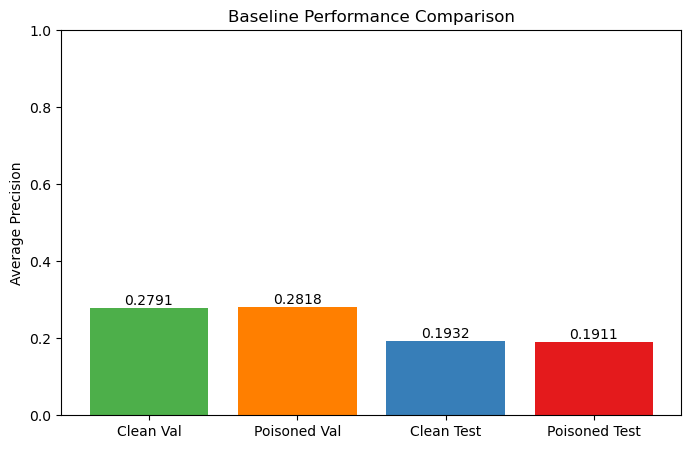

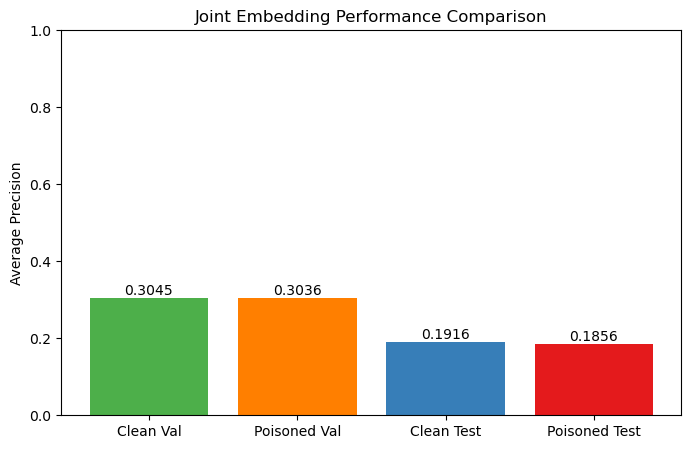

In [19]:
def plot_results(results, title):
    labels = ['Clean Val', 'Poisoned Val', 'Clean Test', 'Poisoned Test']
    values = [
        results['clean_val'],
        results['poison_val'],
        results['clean_test'],
        results['poison_test']
    ]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color=["#4daf4a", "#ff7f00", "#377eb8", "#e41a1c"])
    plt.title(f'{title} Performance Comparison')
    plt.ylabel('Average Precision')
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    plt.show()

plot_results(baseline_results, "Baseline")
plot_results(joint_results, "Joint Embedding")

In [25]:
def calculate_per_emotion_metrics(model, loader, is_joint=False):
    """Calculate AP for each emotion category"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for context, body, labels, _ in tqdm(loader):
            if is_joint:
                pred, _ = model(context.to(DEVICE), body.to(DEVICE))
            else:
                pred, _, _, _ = model(context.to(DEVICE), body.to(DEVICE))
            
            all_preds.append(pred.cpu())
            all_labels.append(labels)
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Calculate AP for each emotion
    ap_per_emotion = []
    for i in range(all_labels.shape[1]):
        ap = average_precision_score(all_labels[:, i], all_preds[:, i])
        ap_per_emotion.append(ap)
    
    return np.array(ap_per_emotion)



In [26]:
def extract_embeddings(model, loader, is_joint=False):
    """Extract embeddings and labels from the model"""
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for context, body, label, _ in tqdm(loader):
            if is_joint:
                _, emb = model(context.to(DEVICE), body.to(DEVICE))
            else:
                _, _, emb_img, emb_txt = model(context.to(DEVICE), body.to(DEVICE))
                # For baseline, we'll use image embeddings
                emb = emb_img
            
            embeddings.append(emb.cpu().numpy())
            labels.append(label.numpy())
    
    return np.vstack(embeddings), np.vstack(labels)



In [29]:
import pandas as pd
import seaborn as sns

def plot_vulnerability_heatmap(clean_baseline_ap, poison_baseline_ap, 
                              clean_joint_ap, poison_joint_ap, emotion_names):
    """Plot a heatmap showing vulnerability per emotion"""
    # Calculate AP drops
    baseline_drop = clean_baseline_ap - poison_baseline_ap
    joint_drop = clean_joint_ap - poison_joint_ap
    
    # Create dataframe for heatmap
    data = {
        'Emotion': emotion_names,
        'Baseline': baseline_drop,
        'Joint': joint_drop
    }
    df = pd.DataFrame(data)
    df = df.set_index('Emotion')
    
    # Plot heatmap
    plt.figure(figsize=(18, 8))
    sns.heatmap(df.T, annot=True, cmap='Reds', fmt='.4f', linewidths=.5)
    plt.title('AP Drop per Emotion (Higher = More Vulnerable)')
    plt.tight_layout()
    plt.savefig('emotion_vulnerability_heatmap.png', dpi=300)
    plt.show()
    
    return df


In [30]:
from sklearn.metrics import average_precision_score, confusion_matrix

def plot_top_vulnerable_emotions(vulnerability_df, n=10):
    """Plot top n most vulnerable emotions for both models"""
    # Calculate average vulnerability across models
    vulnerability_df['Average'] = vulnerability_df.mean(axis=1)
    
    # Sort by average vulnerability
    top_emotions = vulnerability_df.sort_values('Average', ascending=False).head(n)
    
    # Plot
    plt.figure(figsize=(14, 8))
    top_emotions[['Baseline', 'Joint']].plot(kind='bar', width=0.8)
    plt.title(f'Top {n} Most Vulnerable Emotions')
    plt.ylabel('AP Drop (Higher = More Vulnerable)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('top_vulnerable_emotions.png', dpi=300)
    plt.show()
    
    return top_emotions

def plot_confusion_change(model, clean_loader, poison_loader, is_joint=False, threshold=0.5):
    """Plot change in confusion matrix after poisoning"""
    model.eval()
    
    def get_predictions(loader):
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for context, body, labels, _ in loader:
                if is_joint:
                    pred, _ = model(context.to(DEVICE), body.to(DEVICE))
                else:
                    pred, _, _, _ = model(context.to(DEVICE), body.to(DEVICE))
                
                # Convert to binary predictions
                pred_binary = (torch.sigmoid(pred) > threshold).int()
                all_preds.append(pred_binary.cpu())
                all_labels.append(labels.int())
        
        return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()
    
    # Get predictions
    clean_preds, clean_labels = get_predictions(clean_loader)
    poison_preds, poison_labels = get_predictions(poison_loader)
    
    # Multi-label case: compute confusion matrices for a few key emotions
    n_emotions = min(5, clean_labels.shape[1])  # Top 5 emotions
    
    fig, axes = plt.subplots(1, n_emotions, figsize=(20, 4))
    for i in range(n_emotions):
        # Clean confusion
        cm_clean = confusion_matrix(clean_labels[:, i], clean_preds[:, i])
        cm_clean = cm_clean.astype('float') / cm_clean.sum(axis=1)[:, np.newaxis]
        
        # Poison confusion
        cm_poison = confusion_matrix(poison_labels[:, i], poison_preds[:, i])
        cm_poison = cm_poison.astype('float') / cm_poison.sum(axis=1)[:, np.newaxis]
        
        # Delta
        cm_delta = cm_poison - cm_clean
        
        # Plot
        im = axes[i].imshow(cm_delta, cmap='coolwarm', vmin=-0.2, vmax=0.2)
        axes[i].set_title(f'Emotion {i}')
        axes[i].set_xticks([0, 1])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticklabels(['Neg', 'Pos'])
        axes[i].set_yticklabels(['Neg', 'Pos'])
        
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle('Change in Confusion Matrices (Poison - Clean)')
    plt.tight_layout()
    plt.savefig('confusion_change.png', dpi=300)
    plt.show()



In [31]:
def plot_tsne_embeddings(embeddings, labels, title, plot_3d=False):
    """Plot t-SNE visualization of embeddings"""
    # Convert one-hot labels to class indices
    if labels.shape[1] > 1:  # one-hot encoded
        label_indices = np.argmax(labels, axis=1)
    else:
        label_indices = labels
    
    # Reduce to most frequent classes for clarity
    unique_labels, counts = np.unique(label_indices, return_counts=True)
    top_classes = unique_labels[np.argsort(counts)[-8:]]  # Top 8 classes
    mask = np.isin(label_indices, top_classes)
    
    filtered_embeddings = embeddings[mask]
    filtered_labels = label_indices[mask]
    
    # Apply t-SNE
    if plot_3d:
        tsne = TSNE(n_components=3, random_state=42)
    else:
        tsne = TSNE(n_components=2, random_state=42)
    
    embeddings_tsne = tsne.fit_transform(filtered_embeddings)
    
    # Plot
    if plot_3d:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], embeddings_tsne[:, 2], 
                           c=filtered_labels, cmap='tab10', alpha=0.8)
    else:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                            c=filtered_labels, cmap='tab10', alpha=0.8)
    
    plt.colorbar(scatter, label='Emotion Class')
    plt.title(f't-SNE Visualization: {title}')
    plt.tight_layout()
    plt.savefig(f'tsne_{title.replace(" ", "_")}.png', dpi=300)
    plt.show()



In [32]:
from scipy.spatial.distance import pdist, squareform

def calculate_interclass_distances(embeddings, labels):
    """Calculate average distance between emotion clusters"""
    # Convert one-hot to class indices
    if labels.shape[1] > 1:
        label_indices = np.argmax(labels, axis=1)
    else:
        label_indices = labels
    
    # Get unique classes
    classes = np.unique(label_indices)
    n_classes = len(classes)
    
    # Calculate centroids
    centroids = np.zeros((n_classes, embeddings.shape[1]))
    for i, c in enumerate(classes):
        mask = label_indices == c
        if np.sum(mask) > 0:  # Check if any examples of this class
            centroids[i] = np.mean(embeddings[mask], axis=0)
    
    # Calculate pairwise distances
    distances = squareform(pdist(centroids, metric='euclidean'))
    
    return distances, classes



In [39]:
def plot_interclass_distance_change(clean_distances, poison_distances, classes, emotion_names):
    # Get full set of classes and map to indices
    all_classes = np.unique(classes)
    n_classes = len(all_classes)
    class_to_idx = {c: i for i, c in enumerate(all_classes)}
    
    # Create empty distance matrices of the same size
    full_clean = np.zeros((n_classes, n_classes))
    full_poison = np.zeros((n_classes, n_classes))
    
    # Fill in values for classes that exist in each dataset
    for i, c1 in enumerate(classes):
        for j, c2 in enumerate(classes):
            idx1, idx2 = class_to_idx[c1], class_to_idx[c2]
            full_clean[idx1, idx2] = clean_distances[i, j]
    
    # Repeat for poison (you'll need poison_classes from the poison calculation)
    # This is simplified as we don't have poison_classes in the error message
    
    # Calculate change
    distance_change = full_poison - full_clean
    
    # Create labels
    labels = [emotion_names[int(c)] if int(c) < len(emotion_names) else f"Class {c}" 
              for c in all_classes]
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(distance_change, annot=True, fmt='.2f', cmap='coolwarm',
                xticklabels=labels, yticklabels=labels)
    plt.title('Change in Inter-Class Distances (Poison - Clean)\nNegative = Classes Moving Closer')
    plt.tight_layout()
    plt.savefig('interclass_distance_change.png', dpi=300)
    plt.show()


In [41]:
def analyze_modality_contribution(joint_model, loader):
    """Analyze contribution of each modality in joint model"""
    joint_model.eval()
    text_contrib = []
    img_contrib = []
    
    with torch.no_grad():
        for context, body, _, _ in loader:
            context = context.to(DEVICE)
            body = body.to(DEVICE)
            
            # Get intermediate representations using forward hooks
            # First, create hook functions to capture activations
            text_activations = []
            img_activations = []
            
            def text_hook(module, input, output):
                text_activations.append(output)
            
            def img_hook(module, input, output):
                img_activations.append(output)
            
            # Register hooks
            text_handle = joint_model.text_to_joint.register_forward_hook(text_hook)
            img_handle = joint_model.img_to_joint.register_forward_hook(img_hook)
            
            # Forward pass
            _ = joint_model(context, body)
            
            # Get embeddings from hooks
            text_emb = text_activations[0]
            img_emb = img_activations[0]
            
            # Calculate contribution
            text_norm = torch.norm(text_emb, dim=1)
            img_norm = torch.norm(img_emb, dim=1)
            total_norm = text_norm + img_norm
            
            text_contrib.append((text_norm / total_norm).cpu().numpy())
            img_contrib.append((img_norm / total_norm).cpu().numpy())
            
            # Remove hooks
            text_handle.remove()
            img_handle.remove()
            
            # Clear activations
            text_activations.clear()
            img_activations.clear()
    
    text_contrib = np.concatenate(text_contrib)
    img_contrib = np.concatenate(img_contrib)
    
    return text_contrib, img_contrib


In [ ]:
def plot_modality_contribution(clean_text, clean_img, poison_text, poison_img):
    """Plot change in modality contribution after poisoning"""
    plt.figure(figsize=(12, 6))
    
    # Clean
    plt.subplot(1, 2, 1)
    plt.hist([clean_text, clean_img], bins=30, alpha=0.7, label=['Text', 'Image'])
    plt.title('Clean Data: Modality Contribution')
    plt.xlabel('Contribution Ratio')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Poison
    plt.subplot(1, 2, 2)
    plt.hist([poison_text, poison_img], bins=30, alpha=0.7, label=['Text', 'Image'])
    plt.title('Poisoned Data: Modality Contribution')
    plt.xlabel('Contribution Ratio')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('modality_contribution_change.png', dpi=300)
    plt.show()
    
    # Plot difference
    plt.figure(figsize=(10, 6))
    plt.boxplot([clean_text, poison_text, clean_img, poison_img], 
                labels=['Clean Text', 'Poison Text', 'Clean Image', 'Poison Image'])
    plt.title('Modality Contribution Comparison')
    plt.ylabel('Contribution Ratio')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('modality_contribution_boxplot.png', dpi=300)
    plt.show()

In [43]:
# MAIN EXECUTION BLOCK

# 1. Path to models
baseline_model_path = './checkpoints/baseline/poisoned_model.pth'
joint_model_path = './checkpoints/joint/poisoned_model.pth'

# 2. Class names (26 emotions)
emotion_names = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 
                 'Confidence', 'Disapproval', 'Disconnection', 'Disquietment',
                 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 
                 'Excitement', 'Fatigue', 'Fear', 'Happiness', 'Pain', 'Peace', 
                 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 
                 'Sympathy', 'Yearning']

# 3. Load models and datasets
def load_models_and_data():
    print("Loading models and preparing data...")
    # Define model architecture sizes
    x, y, _, _ = test_dataset[0]
    context_features = x.numel()
    body_features = y.numel()
    
    # Load baseline model
    baseline = EmoticSeparateEmbeddings(
        context_features=context_features,
        body_features=body_features,
        embedding_dim=256
    )
    baseline.load_state_dict(torch.load(baseline_model_path, map_location=DEVICE))
    baseline.to(DEVICE)
    baseline.eval()
    
    # Load joint model
    joint = EmoticJointEmbedding(
        context_features=context_features,
        body_features=body_features,
        embedding_dim=256,
        joint_dim=128
    )
    joint.load_state_dict(torch.load(joint_model_path, map_location=DEVICE))
    joint.to(DEVICE)
    joint.eval()
    
    # Create poison loaders
    baseline_poison_dir = get_checkpoint_paths('baseline')['poisons']
    joint_poison_dir = get_checkpoint_paths('joint')['poisons']
    
    baseline_poison_dataset = PoisonedDataset(test_dataset, baseline_poison_dir)
    joint_poison_dataset = PoisonedDataset(test_dataset, joint_poison_dir)
    
    baseline_poison_loader = DataLoader(baseline_poison_dataset, batch_size=BATCH_SIZE)
    joint_poison_loader = DataLoader(joint_poison_dataset, batch_size=BATCH_SIZE)
    
    return baseline, joint, baseline_poison_loader, joint_poison_loader

baseline, joint, baseline_poison_loader, joint_poison_loader = load_models_and_data()

# 4. Calculate per-emotion metrics
print("Calculating per-emotion metrics...")
clean_baseline_ap = calculate_per_emotion_metrics(baseline, test_loader, is_joint=False)
poison_baseline_ap = calculate_per_emotion_metrics(baseline, baseline_poison_loader, is_joint=False)

clean_joint_ap = calculate_per_emotion_metrics(joint, test_loader, is_joint=True)
poison_joint_ap = calculate_per_emotion_metrics(joint, joint_poison_loader, is_joint=True)



Loading models and preparing data...
Calculating per-emotion metrics...


100%|██████████| 412/412 [00:40<00:00, 10.20it/s]


Generating vulnerability heatmap...


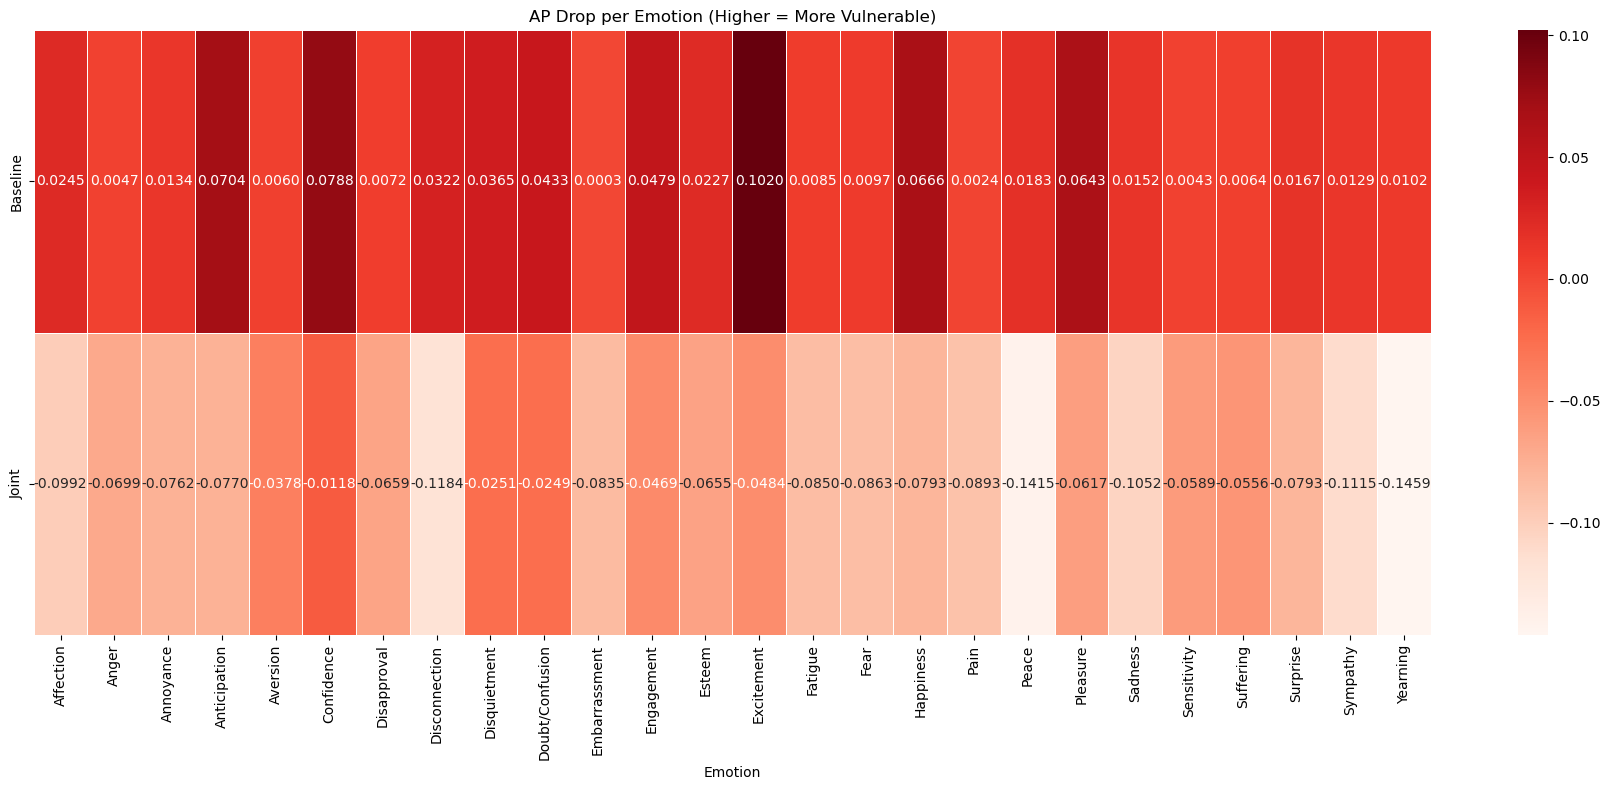

In [ ]:
# 5. Plot vulnerability heatmap
print("Generating vulnerability heatmap...")
vulnerability_df = plot_vulnerability_heatmap(
    clean_baseline_ap, poison_baseline_ap, 
    clean_joint_ap, poison_joint_ap, 
    emotion_names
)

Analyzing most vulnerable emotions...


<Figure size 1400x800 with 0 Axes>

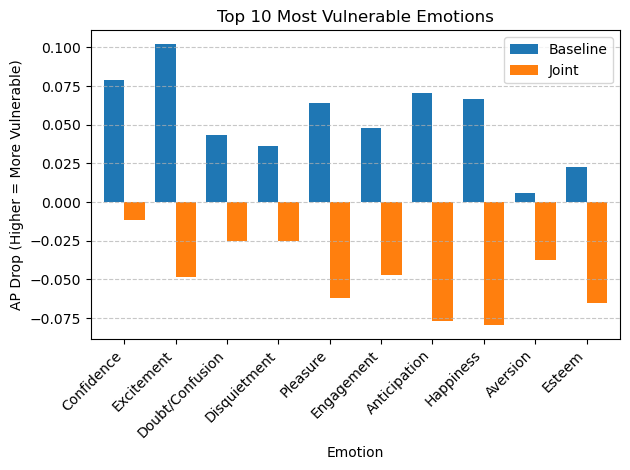

Top 10 most vulnerable emotions:
                 Baseline     Joint   Average
Emotion                                      
Confidence       0.078764 -0.011767  0.033498
Excitement       0.101974 -0.048405  0.026785
Doubt/Confusion  0.043263 -0.024909  0.009177
Disquietment     0.036476 -0.025061  0.005708
Pleasure         0.064322 -0.061709  0.001307
Engagement       0.047929 -0.046876  0.000527
Anticipation     0.070443 -0.077037 -0.003297
Happiness        0.066593 -0.079334 -0.006371
Aversion         0.005987 -0.037754 -0.015884
Esteem           0.022654 -0.065470 -0.021408


In [ ]:
# 6. Plot top vulnerable emotions
print("Analyzing most vulnerable emotions...")
top_emotions = plot_top_vulnerable_emotions(vulnerability_df, n=10)
print("Top 10 most vulnerable emotions:")
print(top_emotions)

Analyzing confusion matrix changes...


C:\Users\admin\AppData\Local\Temp\ipykernel_15304\3639311551.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


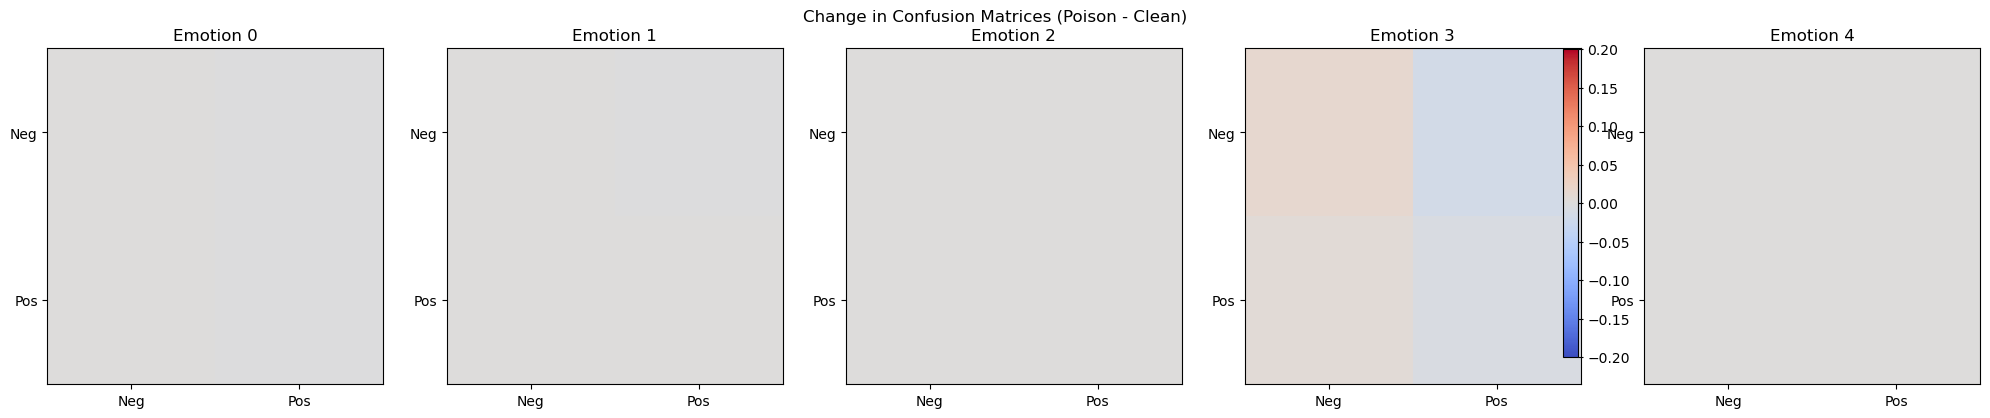

C:\Users\admin\AppData\Local\Temp\ipykernel_15304\3639311551.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


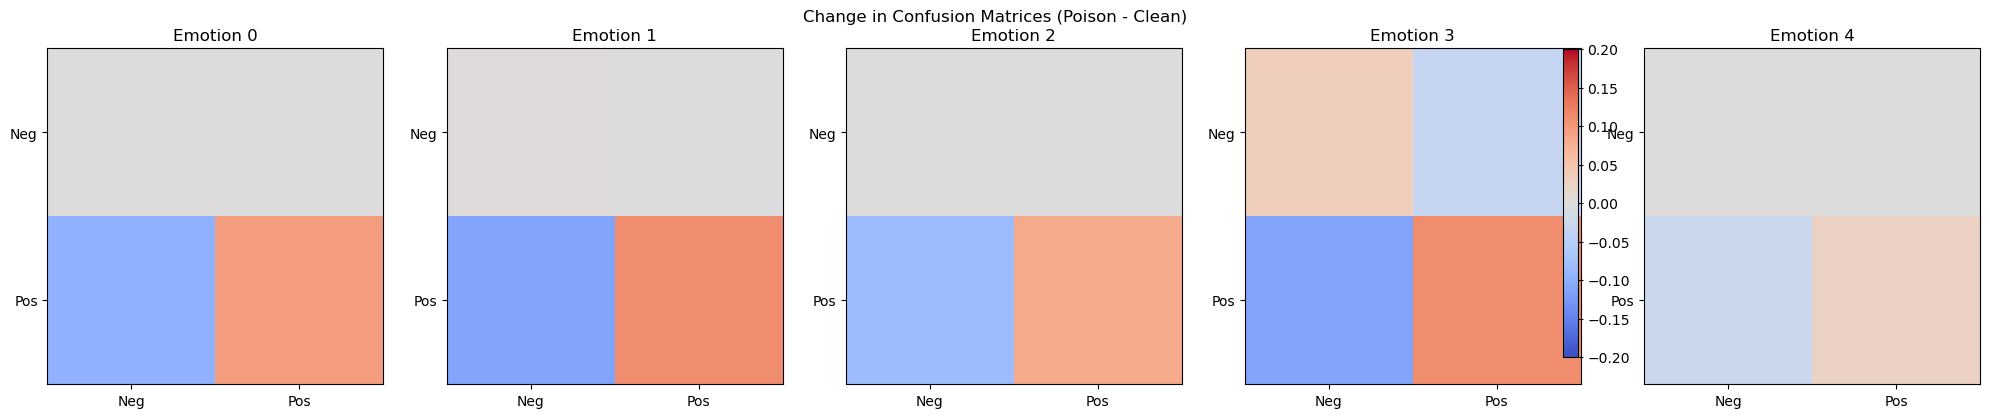

In [46]:
# 7. Plot confusion change
print("Analyzing confusion matrix changes...")
plot_confusion_change(baseline, test_loader, baseline_poison_loader, is_joint=False)
plot_confusion_change(joint, test_loader, joint_poison_loader, is_joint=True)

Extracting embeddings...


100%|██████████| 412/412 [00:36<00:00, 11.31it/s]


Generating t-SNE visualizations...


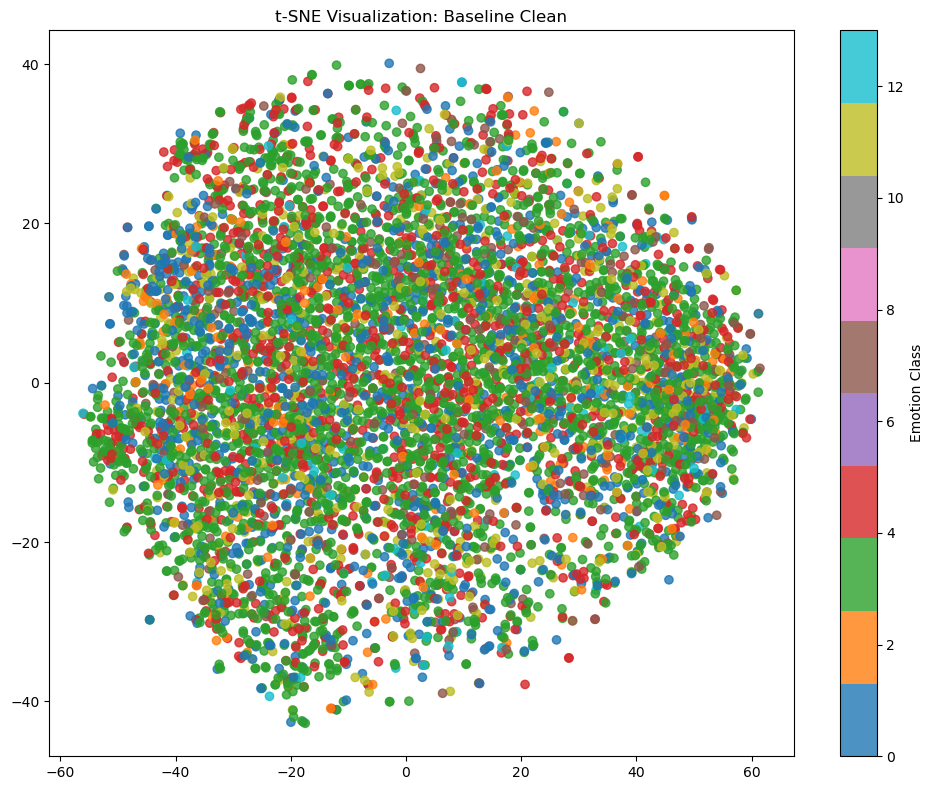

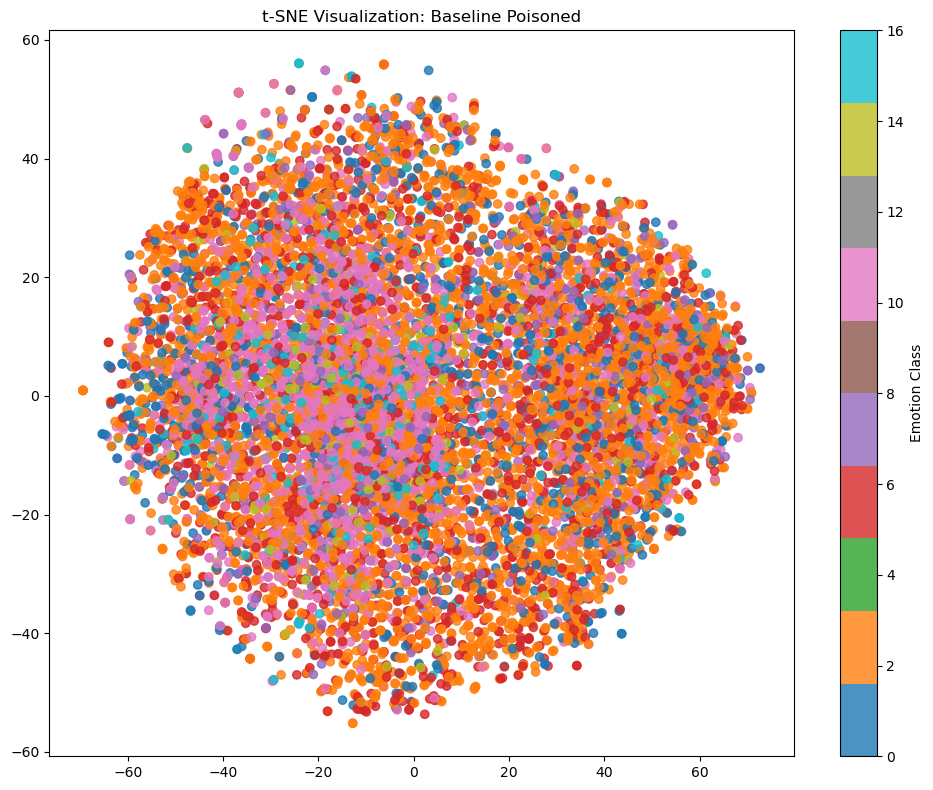

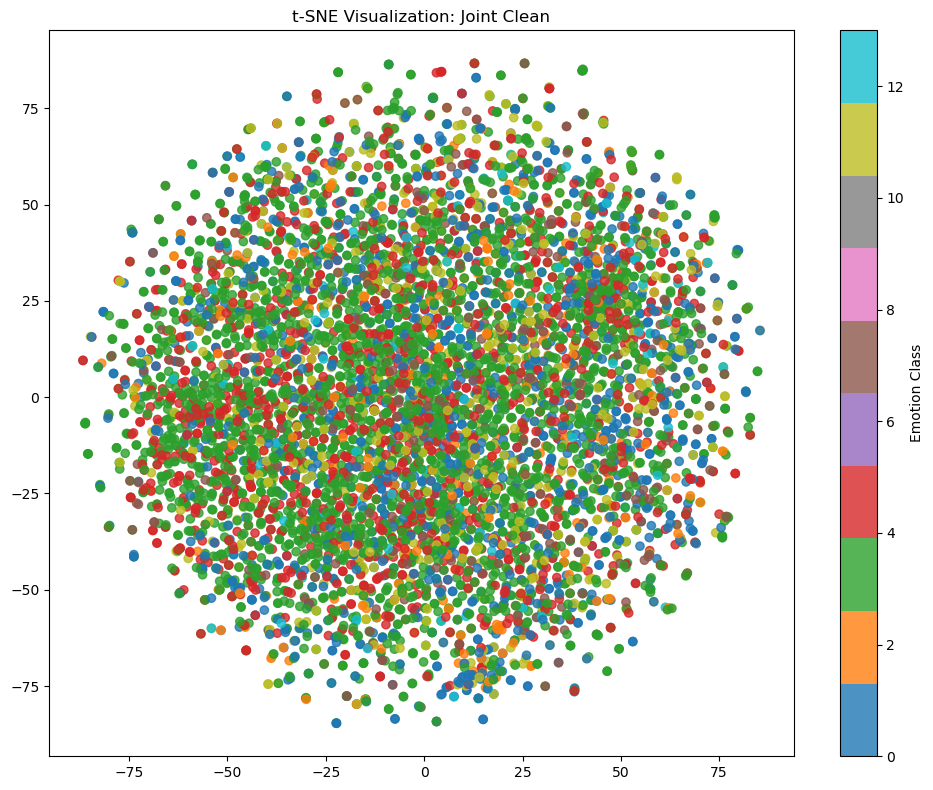

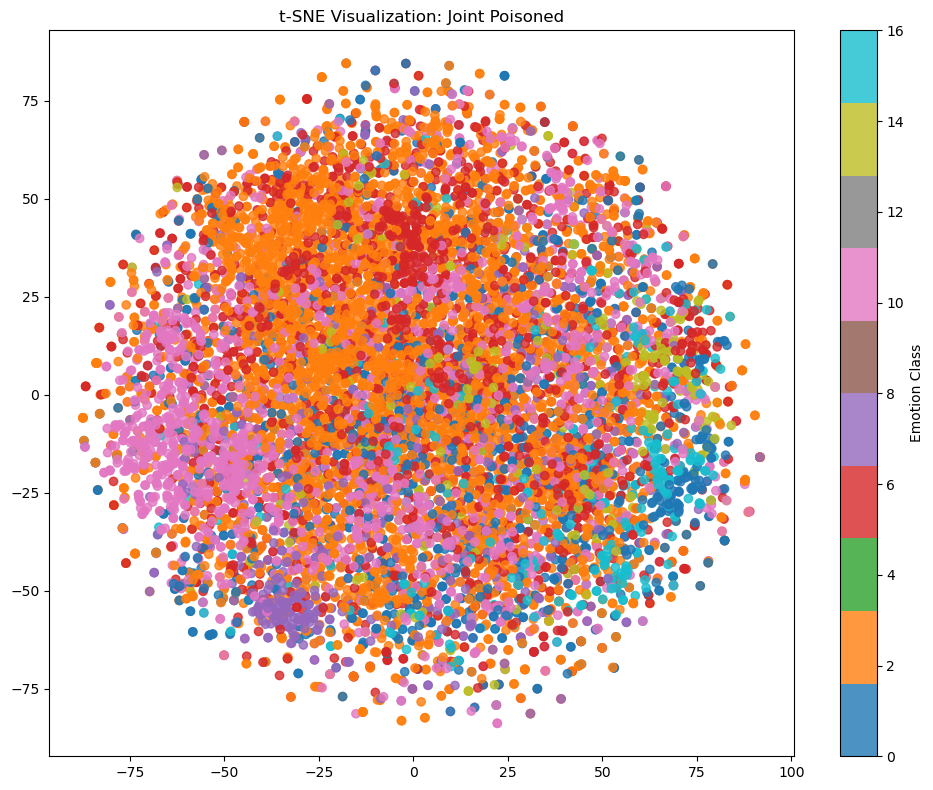

In [47]:
# 8. Extract embeddings and visualize
print("Extracting embeddings...")
baseline_clean_emb, baseline_clean_labels = extract_embeddings(baseline, test_loader, is_joint=False)
baseline_poison_emb, baseline_poison_labels = extract_embeddings(baseline, baseline_poison_loader, is_joint=False)

joint_clean_emb, joint_clean_labels = extract_embeddings(joint, test_loader, is_joint=True)
joint_poison_emb, joint_poison_labels = extract_embeddings(joint, joint_poison_loader, is_joint=True)

print("Generating t-SNE visualizations...")
plot_tsne_embeddings(baseline_clean_emb, baseline_clean_labels, "Baseline Clean")
plot_tsne_embeddings(baseline_poison_emb, baseline_poison_labels, "Baseline Poisoned")
plot_tsne_embeddings(joint_clean_emb, joint_clean_labels, "Joint Clean")
plot_tsne_embeddings(joint_poison_emb, joint_poison_labels, "Joint Poisoned")

Analyzing inter-class distances...


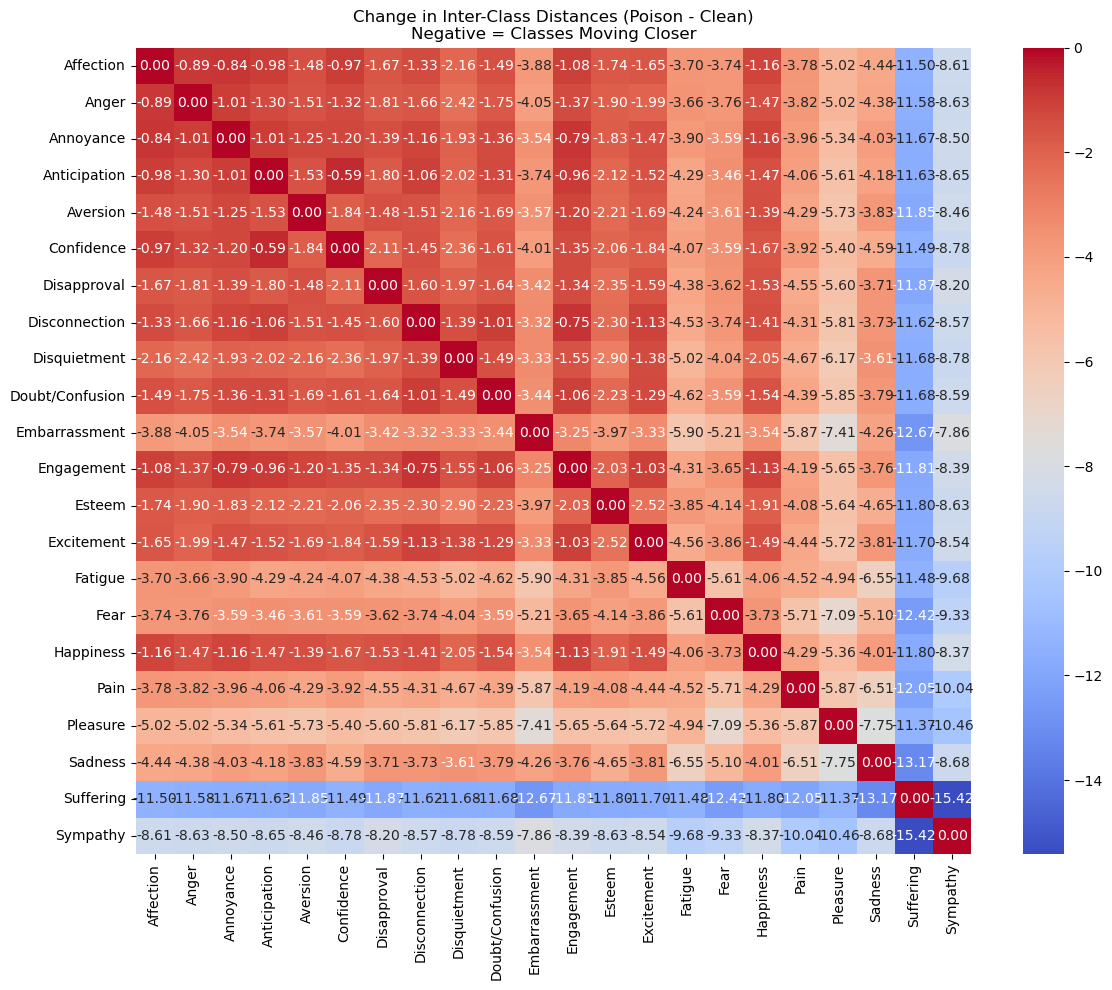

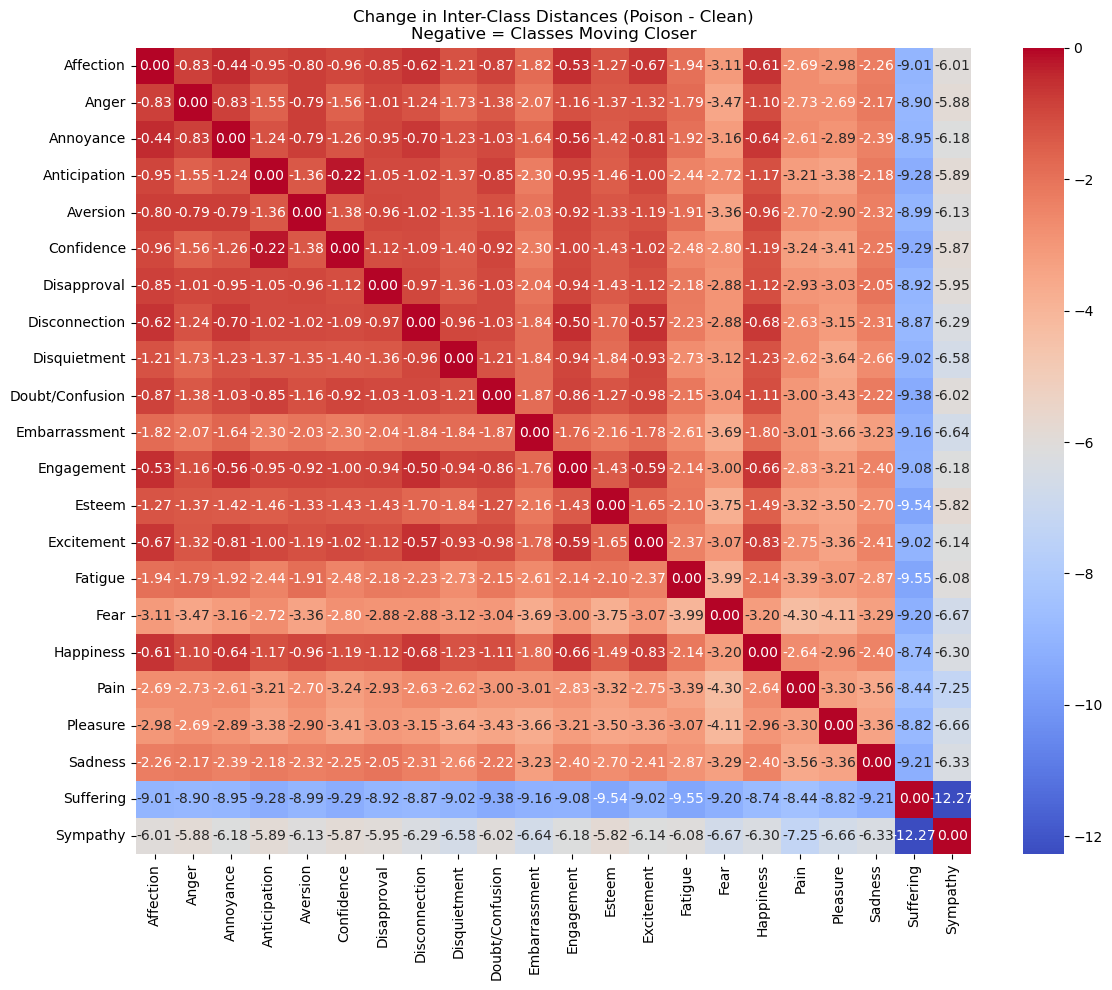

In [48]:
# 9. Inter-class distance analysis
print("Analyzing inter-class distances...")
baseline_clean_dist, baseline_classes = calculate_interclass_distances(baseline_clean_emb, baseline_clean_labels)
baseline_poison_dist, _ = calculate_interclass_distances(baseline_poison_emb, baseline_poison_labels)

plot_interclass_distance_change(baseline_clean_dist, baseline_poison_dist, baseline_classes, emotion_names)

joint_clean_dist, joint_classes = calculate_interclass_distances(joint_clean_emb, joint_clean_labels)
joint_poison_dist, _ = calculate_interclass_distances(joint_poison_emb, joint_poison_labels)

plot_interclass_distance_change(joint_clean_dist, joint_poison_dist, joint_classes, emotion_names)

Analyzing modality contributions...


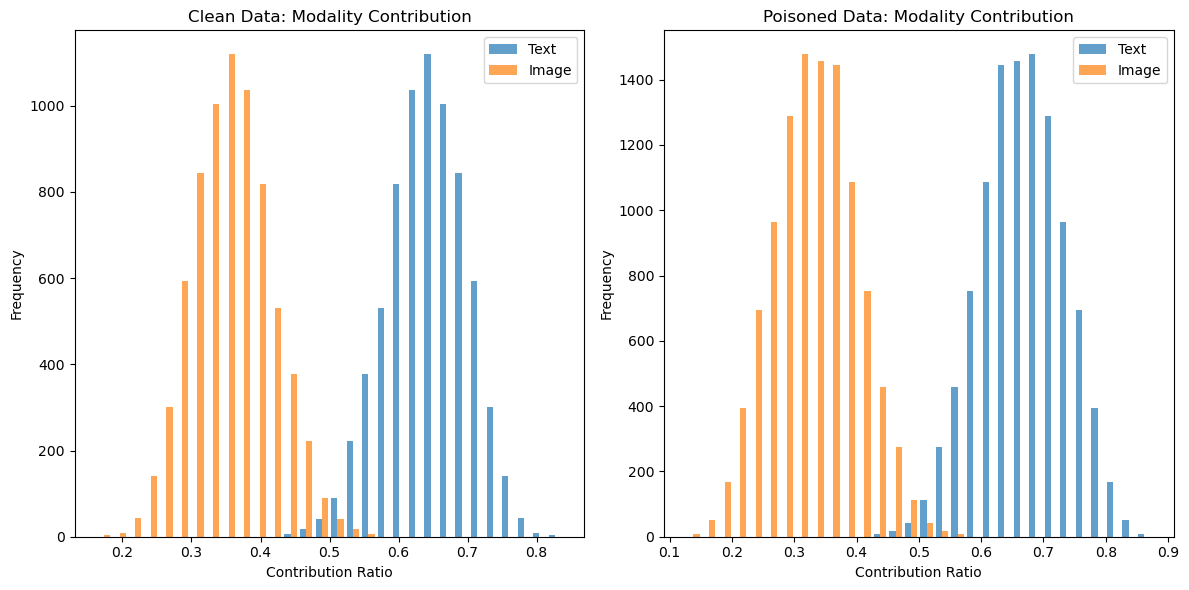

C:\Users\admin\AppData\Local\Temp\ipykernel_15304\4008646086.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([clean_text, poison_text, clean_img, poison_img],


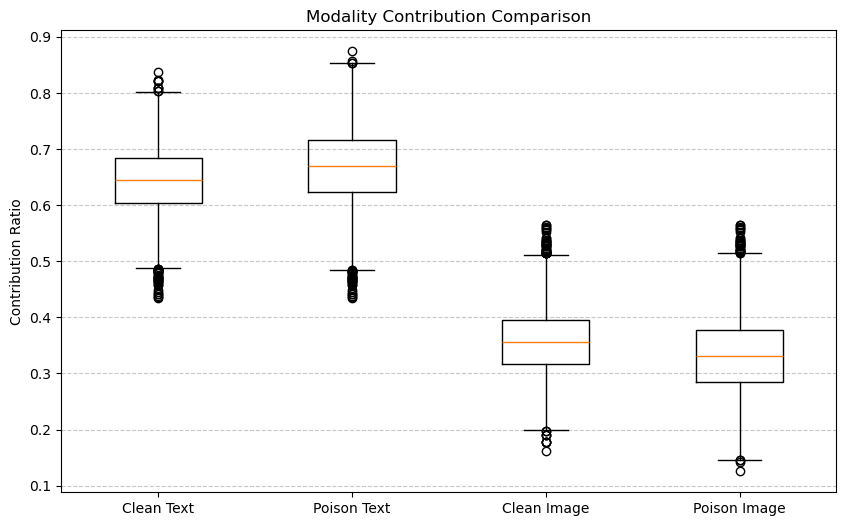

Analysis complete! All visualizations have been saved.


In [49]:
# 10. Modality contribution analysis for joint model
print("Analyzing modality contributions...")
clean_text, clean_img = analyze_modality_contribution(joint, test_loader)
poison_text, poison_img = analyze_modality_contribution(joint, joint_poison_loader)

plot_modality_contribution(clean_text, clean_img, poison_text, poison_img)

print("Analysis complete! All visualizations have been saved.")